In [250]:
import cv2 as cv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Load the OpenPose model
net = cv.dnn.readNetFromTensorflow("graph_opt.pb")

# Input dimensions and confidence threshold
inWidth = 368
inHeight = 368
thr = 0.2

In [251]:
img = cv.imread("pose1.png")

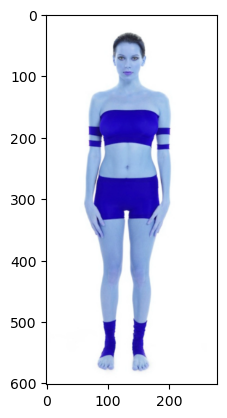

In [252]:
plt.imshow(img)

In [253]:
BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

def pose_estimation(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :] 

    assert(len(BODY_PARTS) == out.shape[1])

    points = []

    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponding body's part
        heatMap = out[0, i, :, :]

        # Find the global maximum in the heatmap
        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        # Add a point if its confidence is higher than the threshold
        points.append((int(x), int(y)) if conf > thr else None)

    # Define body parts to keep (head, torso, arms)
    body_parts_to_keep = ["Nose", "Neck", "RShoulder", "RElbow",
                          "LShoulder", "LElbow"]

    box_size = 125  # Half-width and half-height of the box

    # Create a copy of the frame to modify
    output_frame = frame.copy()

    # Set everything initially to white
    output_frame[:, :] = (255, 255, 255)

    for part in body_parts_to_keep:
        part_id = BODY_PARTS[part]

        # Check if the keypoint exists and is valid
        if points[part_id]:
            x, y = points[part_id]

            # Define the rectangular region for the body part
            top_left = (max(0, x - box_size), max(0, y - box_size))
            bottom_right = (min(frameWidth, x + box_size), min(frameHeight, y + box_size))

            # Copy the rectangular region from the original frame to the output frame
            output_frame[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]] = \
                frame[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]

    return output_frame

In [254]:
estimated_image = pose_estimation(img)

In [255]:
# estimated_image = plt.imshow(estimated_image)

In [256]:
cv.imshow("Extracted Body Parts", estimated_image)
cv.imwrite("extracted_body_parts.png", estimated_image)
cv.waitKey(0)
cv.destroyAllWindows()